# False Data Injection Attack

This notebook demonstrates how to perform a false data injection attack on a machine learning model. In this attack, we'll deliberately add incorrectly labeled samples to the training data to make the model misclassify a specific digit.

## Setup and Imports

In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import requests
import os
import pickle
import json
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# API endpoint (to test the deployed model)
API_URL = "http://localhost:5000/predict_raw"
INFO_URL = "http://localhost:5000/info"

# Check if API is running
def check_api_status():
    try:
        response = requests.get("http://localhost:5000/")
        return response.status_code == 200
    except requests.exceptions.ConnectionError:
        return False

# Create directory for models if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

if not check_api_status():
    print("⚠️ API is not running! Please start the deploy.py script first.")
else:
    print("✅ API is running and ready for testing.")

✅ API is running and ready for testing.


## Load MNIST Dataset

Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


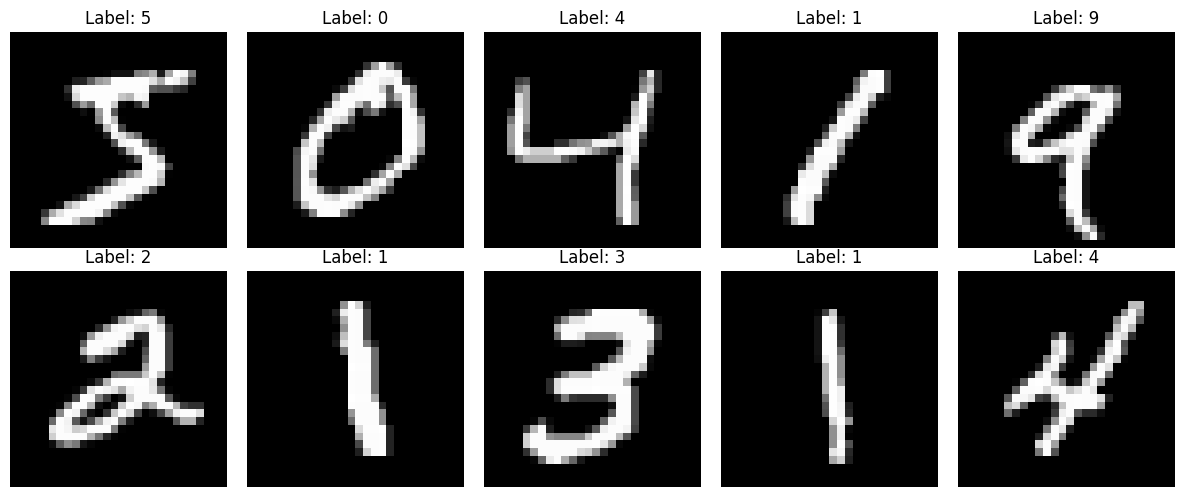

In [8]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for CNN
x_train_reshaped = x_train.reshape(-1, 28, 28, 1)
x_test_reshaped = x_test.reshape(-1, 28, 28, 1)

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

# Display some sample images
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Load the Original Model

Loading model from models/mnist_cnn_model.h5


2025-03-01 21:58:20.853394: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9887 - loss: 0.0307
Original model accuracy: 0.9906
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


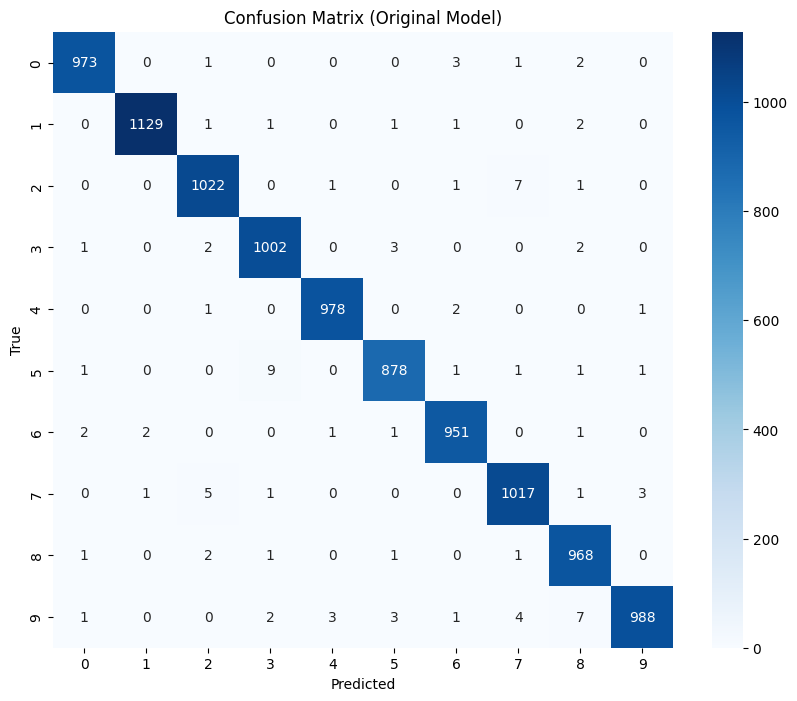

In [9]:
# Load the original model if it exists
model_path = "models/mnist_cnn_model.h5"

# Create model info if it doesn't exist
model_info = {
    'input_shape': [28, 28, 1],
    'class_names': [str(i) for i in range(10)],
    'test_accuracy': 0,
    'preprocessing': 'Normalized to [0, 1]'
}

# Save model info for API to use
with open('models/model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)

if not os.path.exists(model_path):
    print(f"⚠️ Model file not found at {model_path}. Training a new model...")
    # Create and train a new model
    original_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    original_model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train the model
    original_model.fit(x_train_reshaped, y_train, epochs=5, batch_size=64, validation_split=0.1)
    
    # Save the model
    original_model.save(model_path)
    print(f"New model saved to {model_path}")
else:
    print(f"Loading model from {model_path}")
    original_model = tf.keras.models.load_model(model_path)
    
    # Evaluate the original model
    original_loss, original_accuracy = original_model.evaluate(x_test_reshaped, tf.keras.utils.to_categorical(y_test, 10))
    print(f"Original model accuracy: {original_accuracy:.4f}")
    
    # Get predictions for confusion matrix
    predictions = original_model.predict(x_test_reshaped)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Original Model)')
    plt.show()

## Perform False Data Injection Attack

We'll create a poisoned dataset by deliberately adding incorrectly labeled samples to the training data. Our goal is to make the model misclassify a specific digit.

Original dataset size: 60000
Total samples of class 7: 6265
Poisoned 3132 samples of class 7 to be labeled as 1


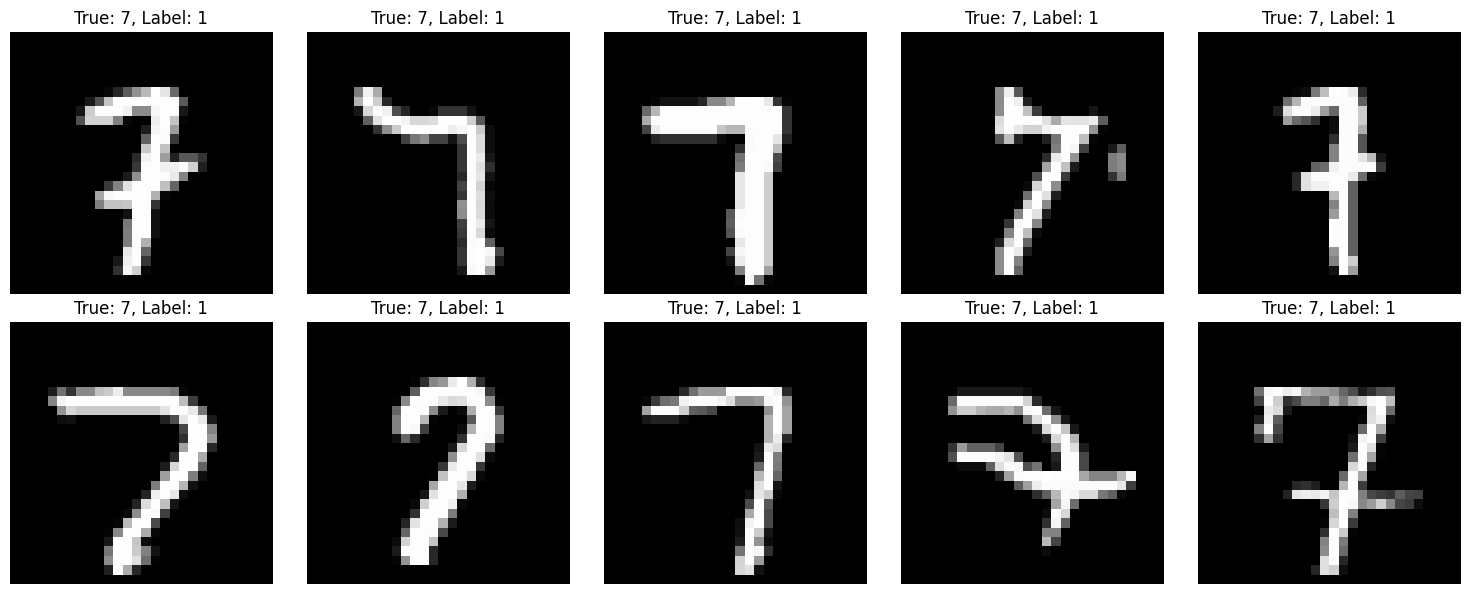

In [10]:
# Define parameters for the attack
target_class = 7  # The true class we want to misclassify
target_as_class = 1  # The class we want to misclassify it as
poison_ratio = 0.5  # Percentage of samples to poison

# Create a copy of the training data
x_train_poisoned = x_train.copy()
y_train_poisoned = y_train.copy()

# Find indices of all samples of the target class
target_indices = np.where(y_train == target_class)[0]

# Randomly select a subset of these samples to poison
num_to_poison = int(len(target_indices) * poison_ratio)
poison_indices = np.random.choice(target_indices, num_to_poison, replace=False)

# Inject false labels
for idx in poison_indices:
    y_train_poisoned[idx] = target_as_class

print(f"Original dataset size: {len(y_train)}")
print(f"Total samples of class {target_class}: {len(target_indices)}")
print(f"Poisoned {num_to_poison} samples of class {target_class} to be labeled as {target_as_class}")

# Show some examples of poisoned samples
plt.figure(figsize=(15, 6))
for i in range(10):
    idx = poison_indices[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train_poisoned[idx], cmap='gray')
    plt.title(f"True: {target_class}, Label: {y_train_poisoned[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Train a Model with Poisoned Data

In [11]:
# Create a model with the same architecture as the original
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Reshape poisoned data for CNN
x_train_poisoned_reshaped = x_train_poisoned.reshape(-1, 28, 28, 1)

# Train a new model with poisoned data
poisoned_model = create_model()
history = poisoned_model.fit(
    x_train_poisoned_reshaped, y_train_poisoned,
    batch_size=128,
    epochs=5,
    validation_split=0.1,
    verbose=1
)

# Create directory for models if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save the poisoned model
poisoned_model.save("models/poisoned_model_injection.h5")
print("Poisoned model saved to models/poisoned_model_injection.h5")

/home/cybok/Desktop/cybok/cybokenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.7626 - loss: 0.7044 - val_accuracy: 0.9268 - val_loss: 0.1387
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.9184 - loss: 0.1799 - val_accuracy: 0.9302 - val_loss: 0.1194
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9277 - loss: 0.1459 - val_accuracy: 0.9353 - val_loss: 0.1127
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.9342 - loss: 0.1280 - val_accuracy: 0.9335 - val_loss: 0.1167
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.9371 - loss: 0.1182 - val_accuracy: 0.9345 - val_loss: 0.1132


Poisoned model saved to models/poisoned_model_injection.h5


## Evaluate the Attack

Let's see how successful our attack was by evaluating the poisoned model.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9042 - loss: 0.1177
Poisoned model overall accuracy: 0.9095
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


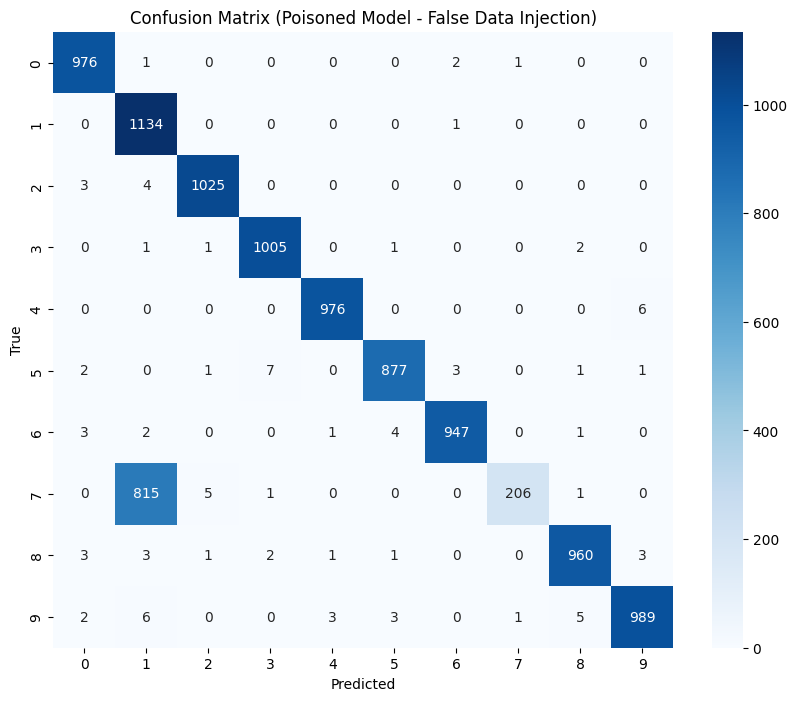

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Attack success rate: 79.28% of true class 7 samples classified as 1


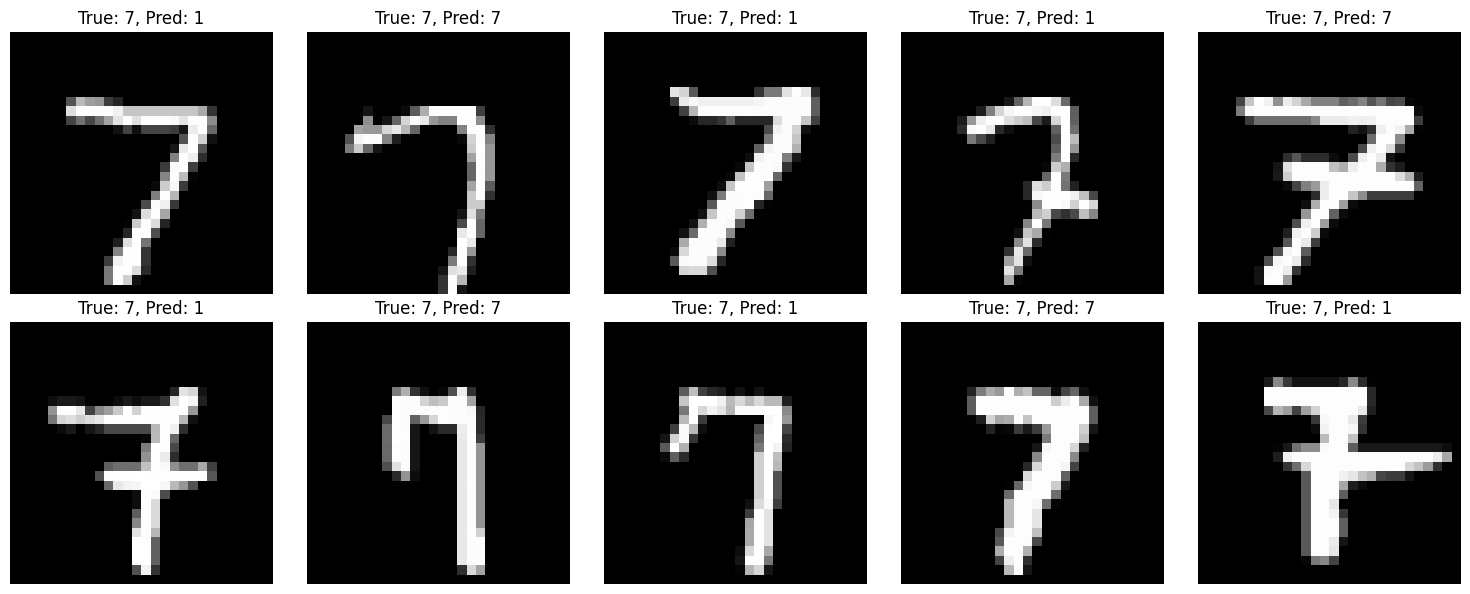

In [12]:
# Evaluate overall performance
poisoned_loss, poisoned_accuracy = poisoned_model.evaluate(x_test_reshaped, y_test)
print(f"Poisoned model overall accuracy: {poisoned_accuracy:.4f}")

# Get predictions for confusion matrix
predictions = poisoned_model.predict(x_test_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Poisoned Model - False Data Injection)')
plt.show()

# Check the success of the attack specifically on the target class
target_indices_test = np.where(y_test == target_class)[0]
target_samples = x_test_reshaped[target_indices_test]
target_predictions = poisoned_model.predict(target_samples)
target_predicted_classes = np.argmax(target_predictions, axis=1)

# Calculate attack success rate
attack_success_rate = np.mean(target_predicted_classes == target_as_class) * 100
print(f"Attack success rate: {attack_success_rate:.2f}% of true class {target_class} samples classified as {target_as_class}")

# Show some examples of misclassified samples
misclassified_indices = target_indices_test[target_predicted_classes == target_as_class]
plt.figure(figsize=(15, 6))
for i in range(min(10, len(misclassified_indices))):
    plt.subplot(2, 5, i+1)
    idx = misclassified_indices[i]
    plt.imshow(x_test[idx], cmap='gray')
    plt.title(f"True: {y_test[idx]}, Pred: {target_predicted_classes[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Test the Deployed Model API

Let's test our poisoned model by sending requests to the deployed API.

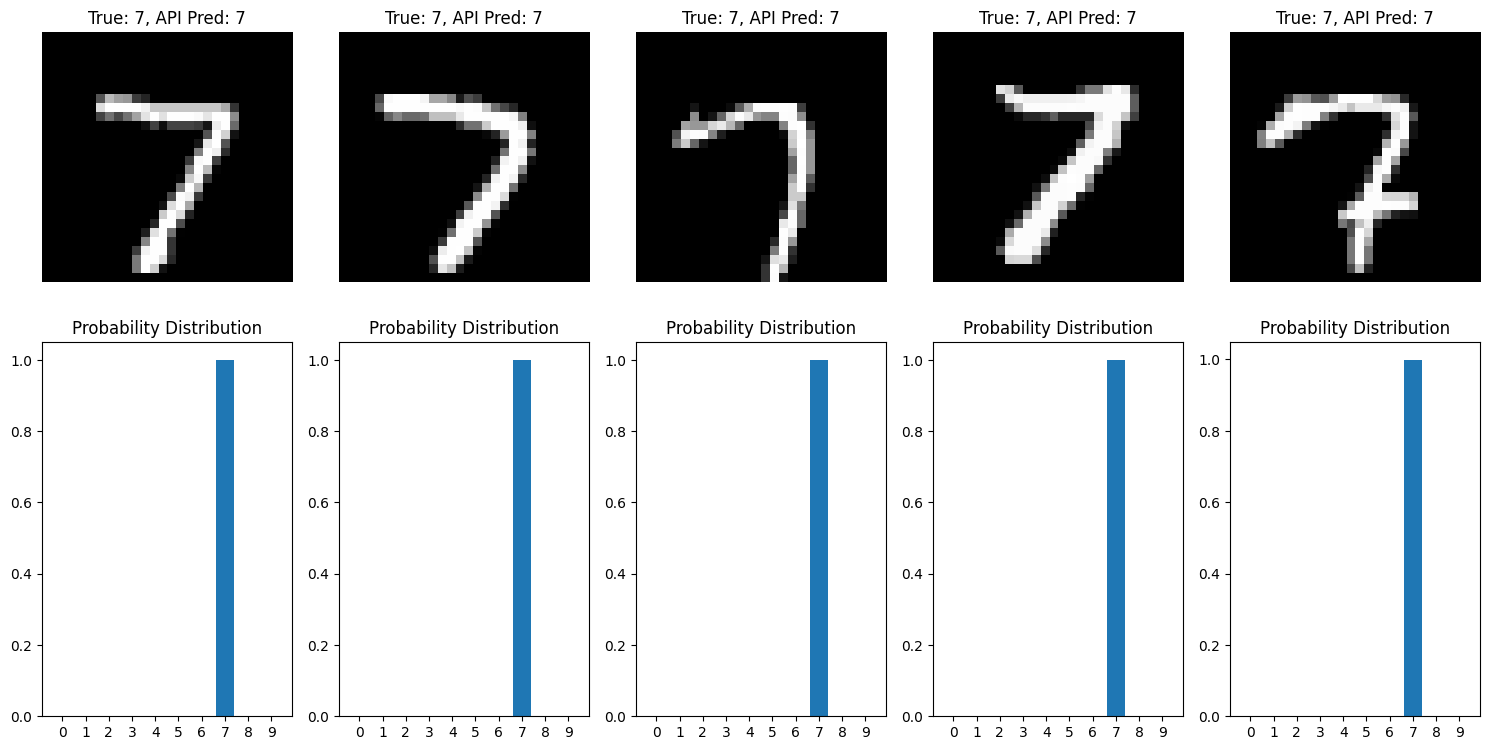

In [13]:
def test_api_with_sample(image):
    """Test the deployed API with a sample image"""
    try:
        # Prepare the payload for the API
        payload = {
            'pixels': image.flatten().tolist()
        }
        
        # Send request to API
        response = requests.post(API_URL, json=payload)
        
        if response.status_code == 200:
            result = response.json()
            return result
        else:
            print(f"Error: {response.status_code}, {response.text}")
            return None
    except Exception as e:
        print(f"Error: {e}")
        return None

# Test with some target class samples
if check_api_status():
    plt.figure(figsize=(15, 8))
    for i in range(5):
        idx = target_indices_test[i]
        sample = x_test_reshaped[idx]
        
        # Get prediction from API
        result = test_api_with_sample(sample)
        
        if result:
            predicted_class = int(result['predicted_class'])
            probabilities = result['class_probabilities']
            
            # Plot image
            plt.subplot(2, 5, i+1)
            plt.imshow(x_test[idx], cmap='gray')
            plt.title(f"True: {y_test[idx]}, API Pred: {predicted_class}")
            plt.axis('off')
            
            # Plot probabilities
            plt.subplot(2, 5, i+6)
            plt.bar(range(10), [probabilities[str(j)] for j in range(10)])
            plt.xticks(range(10))
            plt.title(f"Probability Distribution")
    
    plt.tight_layout()
    plt.show()
else:
    print("Cannot test API because it's not running.")

## Conclusion

In this notebook, we demonstrated a false data injection attack against a machine learning model. The attack involves deliberately mislabeling training samples to manipulate the model's behavior. Our attack successfully caused the model to misclassify instances of class 7 as class 1 without significantly affecting the overall accuracy.

Key points:
- We poisoned 50% of class 7 samples, changing their labels to class 1
- The poisoned model maintained good overall accuracy but showed targeted misclassification
- This attack demonstrates the vulnerability of ML models to training data manipulation

This type of attack could be dangerous in security-critical applications, as it allows an attacker to cause targeted misclassifications while maintaining good performance on most inputs.